In [8]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt

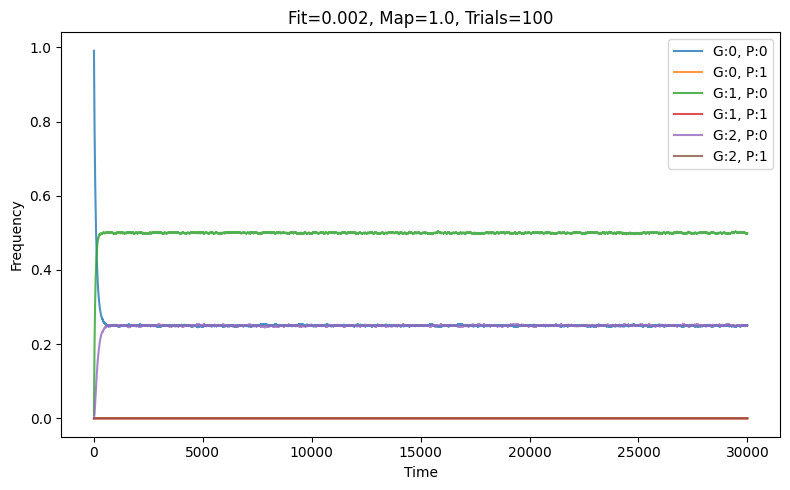

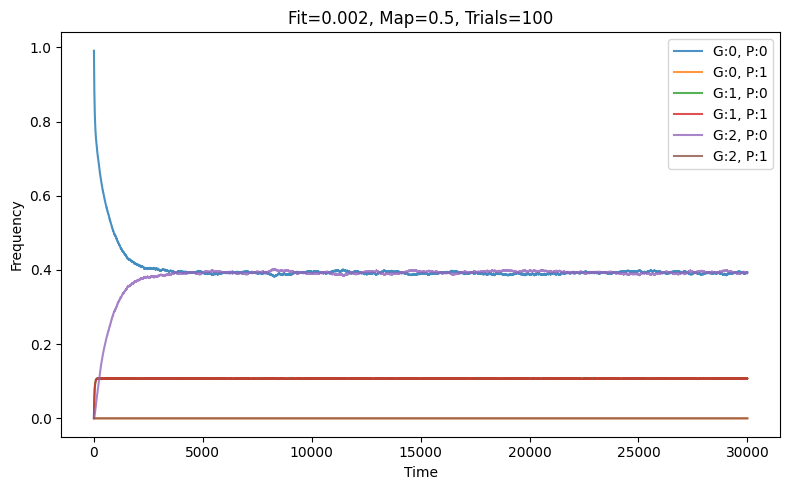

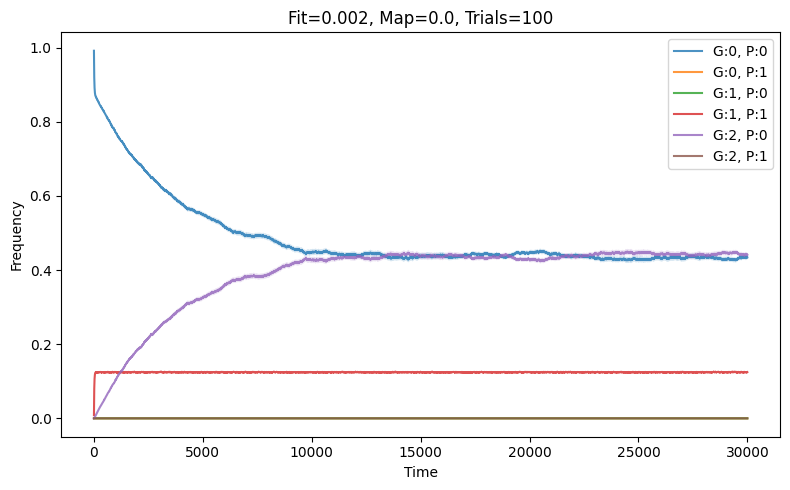

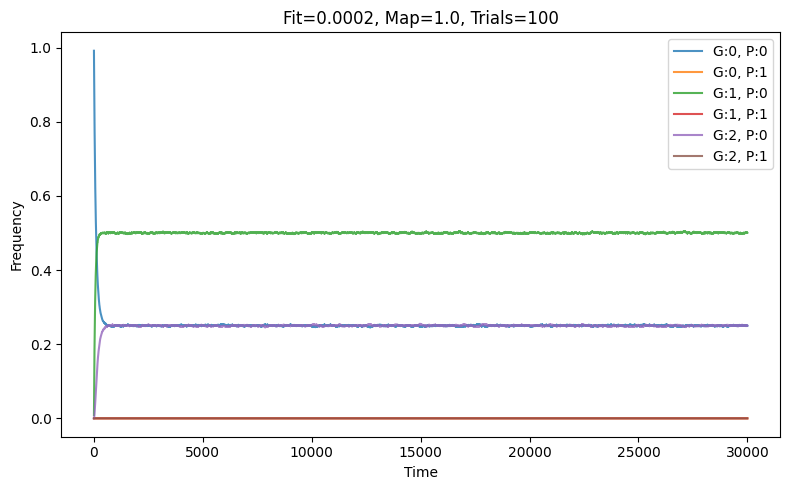

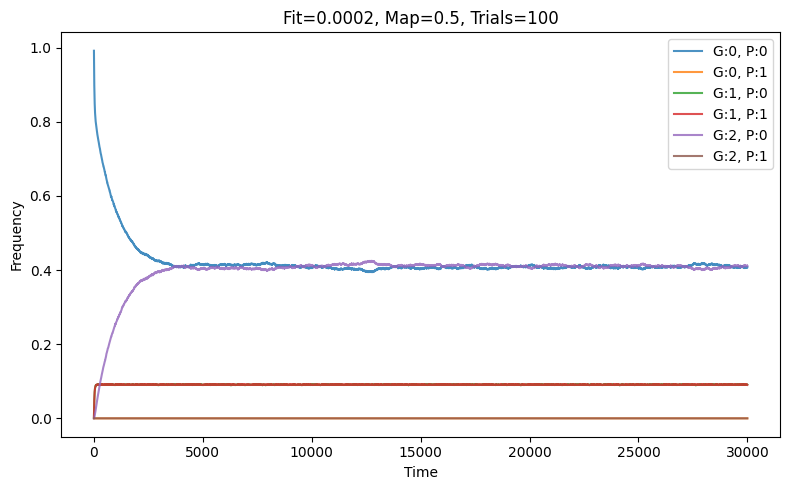

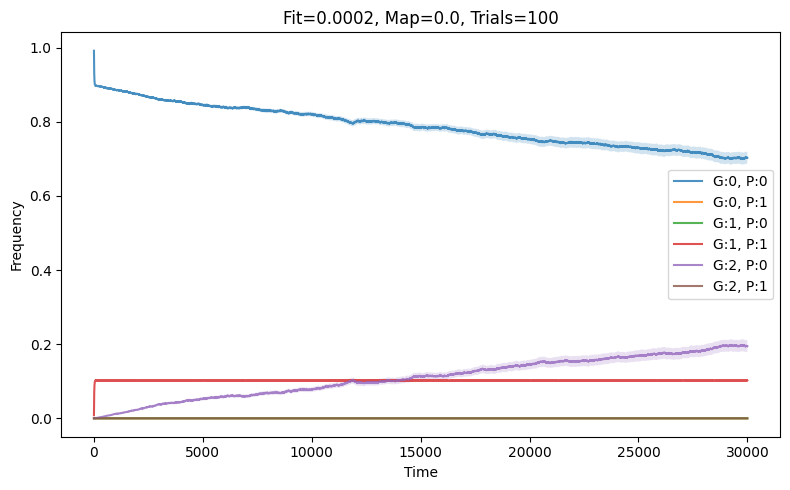

In [11]:
# -------------------------
# Settings
# -------------------------
data_dir = "/data/cb/asapp/VAST/sim_results/bridge_old/bridge"  
fits = ["0.002", "0.0002"]         # fitness values 

# regex to parse filenames
pattern = re.compile(r"sim_data_map_(.*?)_fit_(.*?)_trial_(\d+)\.pkl")

# collect files
files = os.listdir(data_dir)

# organize files by (map, fit)
groups = {}
for fname in files:
    match = pattern.match(fname)
    if match:
        map_val, fit_val, trial = match.groups()
        key = (map_val, fit_val)
        groups.setdefault(key, []).append(os.path.join(data_dir, fname))

# -------------------------
# Compute averages and plot
# -------------------------
for fit in fits:
    map_vals = sorted(
        set(map_val for (map_val, f) in groups.keys() if f == fit),
        key=lambda x: float(x)
    )

    for map_val in map_vals:
        key = (map_val, fit)
        file_list = groups[key]

        trajectories = []

        # load all trials
        for fpath in file_list:
            with open(fpath, "rb") as f:
                data = pickle.load(f)
                # freq_timeseries shape: (Ng, Np, T)
                trajectories.append(data["freq_timeseries"])

        trajectories = np.array(trajectories)  # (num_trials, Ng, Np, T)

        mean_traj = trajectories.mean(axis=0)   # (Ng, Np, T)
        sem_traj = trajectories.std(axis=0) / np.sqrt(len(trajectories))

        # -------------------------
        # Plot each (i,j)
        # -------------------------
        plt.figure(figsize=(8, 5))
        Ng, Np, T = mean_traj.shape
        timepoints = np.arange(T)

        for i in range(Ng):
            for j in range(Np):
                plt.plot(
                    timepoints,
                    mean_traj[i, j, :],
                    label=f"G:{i}, P:{j}",
                    alpha=0.8
                )
                plt.fill_between(
                    timepoints,
                    mean_traj[i, j, :] - sem_traj[i, j, :],
                    mean_traj[i, j, :] + sem_traj[i, j, :],
                    alpha=0.2
                )

        map_val = 1 - float(map_val)
        plt.title(f"Fit={fit}, Map={map_val}, Trials={len(file_list)}")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.show()